# predict txt2img uncertainty and score uncertainty via clip-text-embedding

Input:

- clip-text-embedding:

    np.ndarray, num_sample * (768 * 2), I used concatenate clip_pooler_output of positive and negative prompts.
    
- clip-vision-embedding:

    np.ndarray, num_sample * num_replicates * 768
    
- scoring model:

    pretrained scoring model, use clip-vision-embedding as input

Output:

- txt2img uncertainty predictor:
    
    Linear torch model predict Euclidean variance of CLIP-vision-embedding of generated images, use clip-text-embedding as input
    
- scoring uncertainty predictor:
    
    Linear torch model predict variance of scoring of generated images, use clip-text-embedding as input


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import glob

import torch

import numpy as np
import pandas as pd

import json

from PIL import Image
from matplotlib import pyplot
import seaborn as sns

from tqdm.auto import tqdm

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from utils import get_score_from_embs, init_weights, log_likelihood

In [3]:
BATCH_SIZE = 64

EMB_DIMS = 768

VISION_WEIGHT_PATH = './weight/004/environmental/clip_vision.pt'

# VISION_WEIGHT_PATH = './weight/014/sac+logos+ava1-l14-linearMSE-single.pth'
# VISION_WEIGHT_PATH = './weight/014/sa_0_4_vit_l_14_linear.pth'

# VISION_WEIGHT_PATH = './weight/014/aesthetic-predictor_vision.pt'
# VISION_WEIGHT_PATH = './weight/014/improved-aesthetic-predictor_vision.pt'
# VISION_WEIGHT_PATH = './weight/014/nsfw-detector_vision.pt'

In [4]:
vision_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
vision_model.load_state_dict(torch.load(VISION_WEIGHT_PATH))

<All keys matched successfully>

# load emb

In [5]:
EMB_DIRs = [
    'data/spmi/civitai/',
    'data/spmi/LLM/',
    'data/spmi/environmental/'
]

In [6]:
vision_emb_list = list()
text_emb_list = list()

for emb_dir in EMB_DIRs:

    vision_embs = np.load(os.path.join(emb_dir, 'clip_vision.npy'))

    npz = np.load(os.path.join(emb_dir, 'clip_text.npz'))

    text_positive_embs = npz['positive_pooler_outputs']
    text_negative_embs = npz['negative_pooler_outputs']

    text_embs = np.concatenate([text_positive_embs, text_negative_embs], axis=-1)
    
    vision_emb_list.append(vision_embs)
    text_emb_list.append(text_embs)
    
vision_embs = np.concatenate(vision_emb_list, axis=0)
text_embs = np.concatenate(text_emb_list, axis=0)

In [7]:
# Euclidean distance
var_emb = vision_embs.var(axis=-2).mean(axis=-1)

# # cosine distance
# norm_vision_embs = vision_embs / np.linalg.norm(vision_embs, axis=-1, keepdims=True)
# var_emb = norm_vision_embs.var(axis=-2).mean(axis=-1)

## subset

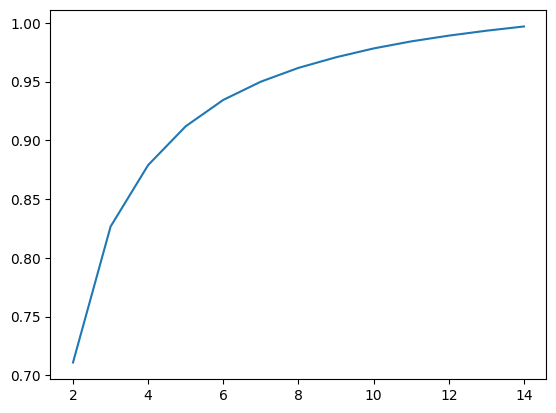

In [11]:
rs = list()

for n_replicates in range(2, vision_embs.shape[1]):

    var_sub = vision_embs[:, :n_replicates].var(axis=-2).mean(axis=-1)

    result = pearsonr(var_emb, var_sub)

    rs.append(result[0])

pyplot.plot(range(2, vision_embs.shape[1]), rs)

# compute score

In [8]:
vision_scores = get_score_from_embs(vision_embs, vision_model, BATCH_SIZE)

  0%|          | 0/744 [00:00<?, ?it/s]

In [9]:
vision_scores = (vision_scores - vision_scores.mean()) / vision_scores.std()

In [10]:
var_score = vision_scores.var(axis=-1)

## subset

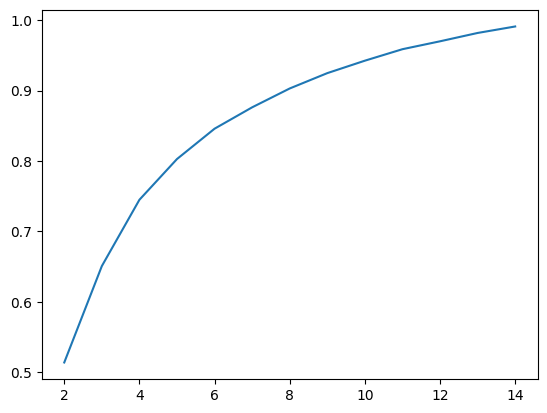

In [17]:
rs = list()

for n_replicates in range(2, vision_scores.shape[1]):

    var_sub = vision_scores[:, :n_replicates].var(axis=-1)

    result = pearsonr(var_score, var_sub)

    rs.append(result[0])

pyplot.plot(range(2, vision_scores.shape[1]), rs)

## compare

PearsonRResult(statistic=0.3328661332637086, pvalue=0.0)


(0.0, 1.0)

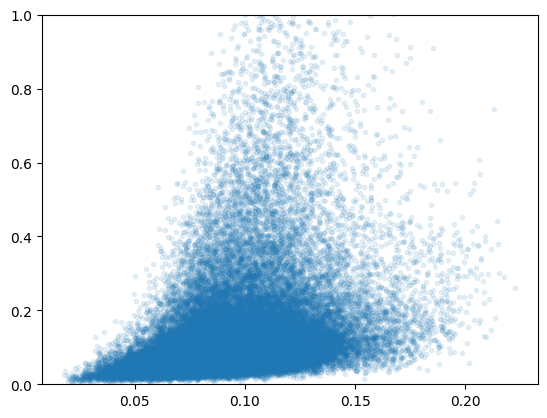

In [18]:
print(pearsonr(var_emb, var_score))
pyplot.plot(var_emb, var_score, '.', alpha=0.1)
pyplot.ylim(0, 1.)

In [8]:
cov = np.cov(vision_embs[0], rowvar=False)

In [9]:
eigvals, eigvecs = torch.linalg.eigh(torch.tensor(cov))

In [13]:
eigvals.shape

torch.Size([768])

# calculate 

In [10]:
X = torch.tensor(vision_embs)

In [11]:
X_centered = X - X.mean(dim=1, keepdim=True)
Cov = torch.matmul(X_centered.transpose(-2, -1), X_centered) / (X.size(1) - 1)

In [15]:
weight = vision_model.weight.detach().cpu()

In [16]:
Y = torch.matmul(torch.matmul(Cov, weight.T).transpose(1,2), weight.T)

In [17]:
pred_var = Y[:, 0,0].detach().cpu().numpy()

PearsonRResult(statistic=0.9999999999999802, pvalue=0.0)


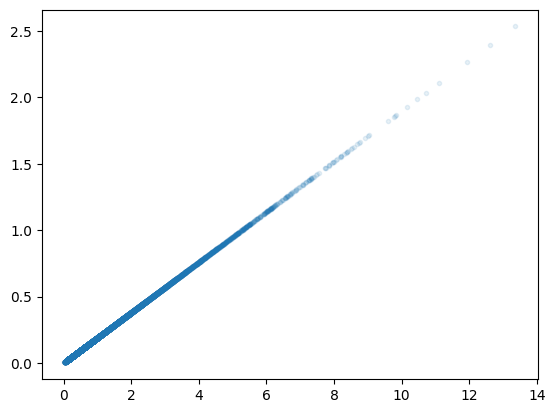

In [26]:
print(pearsonr(pred_var, var_score))
pyplot.plot(pred_var, var_score, '.', alpha=0.1)

# build dataset

In [18]:
embs = text_embs
scores = var_score

# embs = text_embs
# scores = var_emb

In [19]:
train_indices, val_indices = train_test_split(np.arange(embs.shape[0]), test_size=0.2, random_state=42)
np.random.shuffle(train_indices)

In [20]:
train_x = torch.tensor(embs[train_indices]).half().cuda()
train_y = torch.tensor(scores[train_indices]).half().cuda()
val_x = torch.tensor(embs[val_indices]).half()
val_y = torch.tensor(scores[val_indices]).half()

# build model

In [21]:
LR = 1e-4
BATCH_SIZE = 4096
STEPS = 10000

In [22]:
def worker(sub_x, sub_y):

    model = torch.nn.Linear(sub_x.shape[-1], 1).cuda()
    init_weights(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler()
    
    mses, val_mses = list(), list()

    bar = tqdm(total=STEPS, leave=False)

    cur_step = 0
    while cur_step < STEPS:
        
        for i in range(0, sub_x.shape[0], BATCH_SIZE):
        
            model.train()
    
            with torch.cuda.amp.autocast(True):
    
                optimizer.zero_grad()
    
                y = model(sub_x[i:i+BATCH_SIZE])
    
            # backward
    
            mse = torch.nn.functional.l1_loss(y, sub_y[i:i+BATCH_SIZE, None])
            # mse = torch.nn.functional.mse_loss(y, sub_y[i:i+BATCH_SIZE, None])
            
            loss = mse
    
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            mses.append(mse.detach().cpu().numpy())

            bar.update()
            cur_step += 1
    
            if (cur_step + 1) % 100 == 0:
            
                with torch.no_grad():
                    with torch.cuda.amp.autocast(True):

                        val_mse = list()
                
                        for i in range(0, val_x.shape[0], BATCH_SIZE):
                            y = model(val_x[i:i+BATCH_SIZE].cuda())
            
                            mse = torch.nn.functional.l1_loss(y, val_y[i:i+BATCH_SIZE, None].cuda())
                            # mse = torch.nn.functional.mse_loss(y, val_y[i:i+BATCH_SIZE, None].cuda())

                            val_mse.append(mse.detach().cpu().numpy())
                        val_mses.append(np.mean(val_mse))

    return model, mses, val_mses

In [23]:
ratios = [1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]

mses = list()
val_mses = list()

for ratio in ratios:

    # n_clusters = int(ratio * train_x.shape[0])
    # kmeans = MiniBatchKMeans(n_clusters=n_clusters, max_iter=100, n_init=3)
    # x = embs[train_indices] / np.linalg.norm(embs[train_indices], axis=1, keepdims=True)
    # kmeans.fit_predict(x)
    # dists = cosine_similarity(x, kmeans.cluster_centers_)
    # indices = list(set(np.argmax(dists, axis=0)))

    indices = np.random.choice(np.arange(train_x.shape[0]), int(ratio * train_x.shape[0]), False)

    model, mse, val_mse = worker(train_x[indices], train_y[indices])

    mses.append(mse)
    val_mses.append(val_mse)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

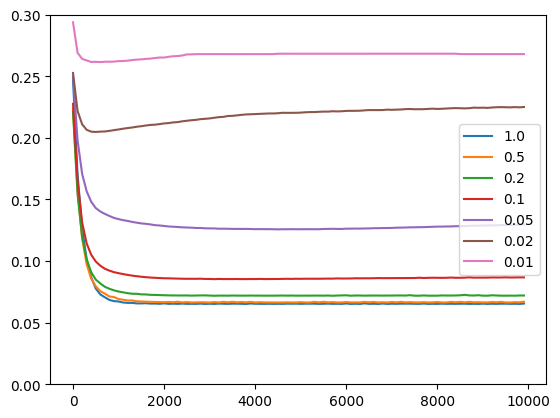

In [24]:
for ratio, mse, val_mse in zip(ratios, mses, val_mses):
    # pyplot.plot(mse)
    pyplot.plot(range(0, len(mse), 100), val_mse, label=ratio)
pyplot.ylim(0, 0.3)
pyplot.legend()

In [104]:
pred_scores = get_score_from_embs(embs, model, BATCH_SIZE)

  0%|          | 0/12 [00:00<?, ?it/s]

PearsonRResult(statistic=-0.007119722199501711, pvalue=0.12039373556620826)


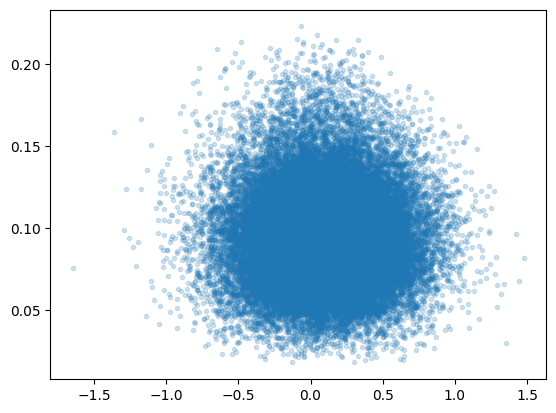

In [105]:
print(pearsonr(pred_scores, scores))
pyplot.plot(pred_scores, scores, '.', alpha=0.2)

In [36]:
# OUTPUT_PATH = './weight/027/004-environmental-clip_vision-var.pt'
OUTPUT_PATH = './weight/027/clip_vision-var.pt'
os.makedirs(os.path.split(OUTPUT_PATH)[0], exist_ok=True)
torch.save(model.state_dict(), OUTPUT_PATH)

In [93]:
embs.shape

(47588, 1536)